## **COMP9727: Content-Based Music Recommendation**

##### **Written by:** Sam Harrison (z5217483)

### **Part 1: Topic Classification**

##### **Question 1**

**Regex**

The regex in the tutorial notebook removes all non-word and non-whitespace characters from the data. Whilst many of these special characters can be safely removed without affecting the meaning of the text, some characters such as the apostrophe may carry significant meaning. Additionally, this dataset contains many instances of the "&" and ":" characters, which are likely to be meaningful in the context of highly curated text like a song's metadata. As such, the following changes to the text preprocessing should be evaluated.

- Update the regex to keep the "&", "'" and ":" characters
- Update the regex to keep the above 3 characters as well as the "-" character


##### **Question 2**

**Step 1: Load the dataset and remove any duplicate or missing values**

In [260]:
import pandas as pd

# Load the dataset 
df = pd.read_csv("dataset.tsv", sep="\t")

# Concatenate the first 5 fields into a single document
df['Content'] = df[['artist_name', 'track_name', 'release_date', 'genre', 'lyrics']].astype(str).agg(' '.join, axis=1)

# Remove any duplicate or missing values
df = df.drop_duplicates()
df = df.dropna()

**Step 2: Define preprocessing function with options**

In [261]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

ps = PorterStemmer()
wnl = WordNetLemmatizer()

# Define the text preprocessing function with option type parameters 
def preprocess_text(text, stopwords_type, stem_or_lemma, regex_type, use_lowercase):
    
    if use_lowercase:
        text = text.lower()

    if regex_type == 'strict':
        text = re.sub(r"[^\w\s]", '', text)
    elif regex_type == 'relaxed':
        text = re.sub(r"[^\w\s'&:]", "", text)
    elif regex_type == 'relaxed_with_hyphen':
        text = re.sub(r"[^\w\s'&:-]", "", text)

    tokens = word_tokenize(text)
    
    if stopwords_type == 'nltk':
        stop_words_set = set(stopwords.words('english')) 
    else:
        stop_words_set = ENGLISH_STOP_WORDS
        
    tokens = [word for word in tokens if word not in stop_words_set]

    if stem_or_lemma == 'stem':
        tokens = [ps.stem(word) for word in tokens]
    else:
        tokens = [wnl.lemmatize(word) for word in tokens]
    
    return ' '.join(tokens)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/samharrison/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/samharrison/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/samharrison/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


**Step 3: Evaluate combinations of preprocessing options**

In [262]:
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from itertools import product

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['topic'])

# Define possible options for each preprocessing step
stopwords_options = ['nltk', 'sklearn']
shortening_options = ['stem', 'lemma']
regex_options = ['strict', 'relaxed', 'relaxed_with_hyphen']
lowercase_options = [True, False]
model_options = [('MNB', MultinomialNB(), False), ('BNB', BernoulliNB(), True)]

results = []

# Evaluate all combinations of preprocessing options
for stopwords_type, shortening_type, regex_type, use_lowercase in product(stopwords_options, shortening_options, regex_options, lowercase_options):
    processed = df['Content'].apply(lambda x: preprocess_text(x, stopwords_type, shortening_type, regex_type, use_lowercase))

    for model_name, model, binary in model_options:
        vectorizer = CountVectorizer(binary=binary)
        X = vectorizer.fit_transform(processed)
        
        acc = cross_val_score(model, X, y, cv=5, scoring='accuracy').mean()
        
        results.append({
            'model': model_name,
            'stopwords': stopwords_type,
            'shortening': shortening_type,
            'regex': regex_type,
            'lowercase': use_lowercase,
            'accuracy': acc
        })

results_df = pd.DataFrame(results)

top_mnb = results_df[results_df['model'] == 'MNB'].nlargest(10, 'accuracy')
top_bnb = results_df[results_df['model'] == 'BNB'].nlargest(10, 'accuracy')

print('Top 10 MNB configurations')
display(results_df[results_df['model'] == 'MNB'].nlargest(10, 'accuracy'))

print('Top 10 BNB configurations')
display(results_df[results_df['model'] == 'BNB'].nlargest(10, 'accuracy'))

Top 10 MNB configurations


,model,stopwords,shortening,regex,lowercase,accuracy
12,MNB,nltk,lemma,strict,True,0.790541
14,MNB,nltk,lemma,strict,False,0.790541
16,MNB,nltk,lemma,relaxed,True,0.790541
18,MNB,nltk,lemma,relaxed,False,0.790541
20,MNB,nltk,lemma,relaxed_with_hyphen,True,0.789865
22,MNB,nltk,lemma,relaxed_with_hyphen,False,0.789865
0,MNB,nltk,stem,strict,True,0.785811
2,MNB,nltk,stem,strict,False,0.785811
4,MNB,nltk,stem,relaxed,True,0.785811
6,MNB,nltk,stem,relaxed,False,0.785811


Top 10 BNB configurations


,model,stopwords,shortening,regex,lowercase,accuracy
25,BNB,sklearn,stem,strict,True,0.527703
27,BNB,sklearn,stem,strict,False,0.527703
29,BNB,sklearn,stem,relaxed,True,0.527027
31,BNB,sklearn,stem,relaxed,False,0.527027
1,BNB,nltk,stem,strict,True,0.526351
3,BNB,nltk,stem,strict,False,0.526351
9,BNB,nltk,stem,relaxed_with_hyphen,True,0.525000
11,BNB,nltk,stem,relaxed_with_hyphen,False,0.525000
33,BNB,sklearn,stem,relaxed_with_hyphen,True,0.525000
35,BNB,sklearn,stem,relaxed_with_hyphen,False,0.525000


**Selected Preprocessing Configuration**

The results displayed above indicate that MNB achieves significantly greater accuracy than BNB. As such, it is best to optimise the preprocessing configuration for the MNB classifier. Based on the accuracy scores of the different preprocessing configurations for the MNB classifier, the NLTK stopwords and Lemmatization will be used. Whilst the strict and relaxed regex (without hyphens) result in the same accuracy, given the dataset consists of curated song metadata with minimal redundant information, the relaxed regex should be used to preserve meaningful symbols. 

- **Regex:** Relaxed (apostrophes, ampersands and colons) [^\w\s'&:]
- **Lowercasing:** True
- **Stopword removal:** NLTK stopwords
- **Word processing:** Lemmatization

**Step 4: Apply the selected preprocessing steps to the dataset**

In [263]:
df['Processed'] = df['Content'].apply(
    lambda x: preprocess_text(x, 'nltk', 'lemma', 'relaxed', True)
    )

print(df['Processed'].head())

0    loving real lake 2016 rock awake know go see t...
1    incubus summer 2019 rock summer pretty build s...
2    reignwolf hardcore 2016 blue lose deep catch b...
3    tedeschi truck band anyhow 2016 blue run bitte...
4    lukas nelson promise real started 2017 blue th...
Name: Processed, dtype: object


##### **Question 3**

**Step 1: Assess the balance of the dataset**

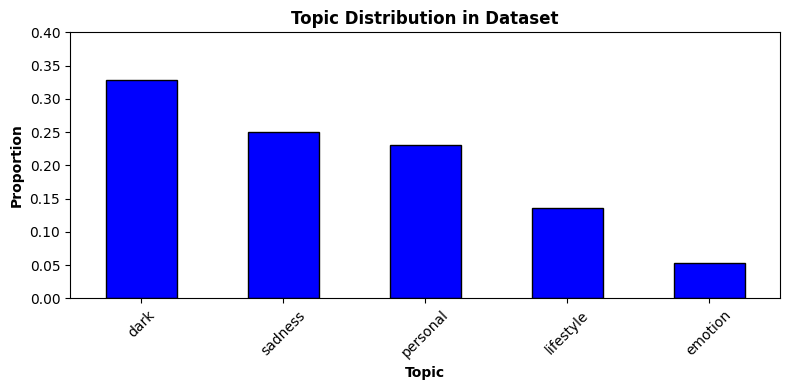

Imbalance ratio: 6.1645569620253164


In [264]:
import matplotlib.pyplot as plt

topic_distribution = df['topic'].value_counts(normalize=True)

plt.figure(figsize=(8, 4))
topic_distribution.plot(kind='bar', color='b', edgecolor='black')
plt.title('Topic Distribution in Dataset', fontweight='bold')
plt.ylabel('Proportion', fontweight='bold')
plt.xlabel('Topic', fontweight='bold')
plt.ylim(0, 0.4)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

topic_imbalance_ratio = topic_distribution.max() / topic_distribution.min()
print(f'Imbalance ratio: {topic_imbalance_ratio}')

**Select metrics to evaluate overall accuracy of BNB and MNB**

In [265]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report

vectorizer = CountVectorizer(binary=False)
X = vectorizer.fit_transform(df['Processed'])
y = label_encoder.fit_transform(df['topic'])

mnb = MultinomialNB()
mnb_preds = cross_val_predict(mnb, X, y, cv=5)

print('MultinomialNB Classification Report')
print(classification_report(y, mnb_preds, target_names=label_encoder.classes_))

bnb = BernoulliNB()
X_bnb = CountVectorizer(binary=True).fit_transform(df['Processed'])
bnb_preds = cross_val_predict(bnb, X_bnb, y, cv=5)

print('BernoulliNB Classification Report')
print(classification_report(y, bnb_preds, target_names=label_encoder.classes_))


MultinomialNB Classification Report
              precision    recall  f1-score   support

        dark       0.81      0.83      0.82       487
     emotion       0.50      0.28      0.36        79
   lifestyle       0.85      0.69      0.76       202
    personal       0.84      0.81      0.83       341
     sadness       0.74      0.89      0.81       371

    accuracy                           0.79      1480
   macro avg       0.75      0.70      0.71      1480
weighted avg       0.79      0.79      0.78      1480

BernoulliNB Classification Report
              precision    recall  f1-score   support

        dark       0.60      0.75      0.67       487
     emotion       0.00      0.00      0.00        79
   lifestyle       0.08      0.00      0.01       202
    personal       0.67      0.29      0.41       341
     sadness       0.44      0.84      0.58       371

    accuracy                           0.52      1480
   macro avg       0.36      0.38      0.33      1480
weighte

Based on these results, MNB is clearly superior to BNB on precision, recall and F1 score and should therefore be used. 

##### **Question 4**

**Total number of features in the dataset**

In [266]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['Processed'])

total_features = len(vectorizer.vocabulary_)

print(f'Total number of features: {total_features}')

Total number of features: 9437


**Test different values for N**

,model,num_features,accuracy
0,BNB,100,0.532432
1,MNB,100,0.742568
2,BNB,250,0.623649
3,MNB,250,0.848649
4,BNB,350,0.641216
5,MNB,350,0.865541
6,BNB,500,0.654054
7,MNB,500,0.864865
8,BNB,1000,0.632432
9,MNB,1000,0.839189


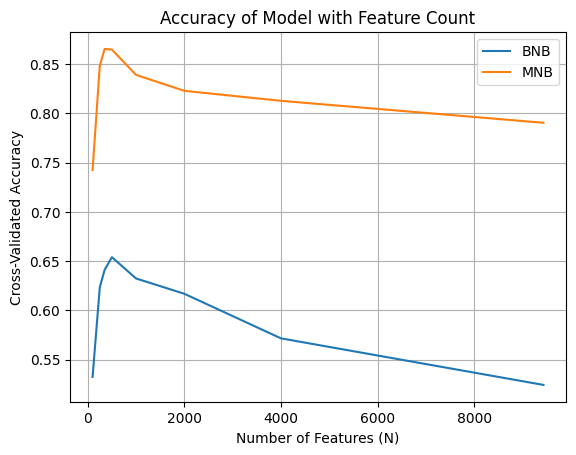

In [267]:
n_values = [100, 250, 350, 500, 1000, 2000, 4000, total_features]

results = []

for n in n_values:
    vectorizer = CountVectorizer(max_features=n, binary=True)
    X_bnb = vectorizer.fit_transform(df['Processed'])
    acc_bnb = cross_val_score(BernoulliNB(), X_bnb, y, cv=5, scoring='accuracy').mean()
    
    vectorizer = CountVectorizer(max_features=n, binary=False)
    X_mnb = vectorizer.fit_transform(df['Processed'])
    acc_mnb = cross_val_score(MultinomialNB(), X_mnb, y, cv=5, scoring='accuracy').mean()
    
    results.append({'model': 'BNB', 'num_features': n, 'accuracy': acc_bnb})
    results.append({'model': 'MNB', 'num_features': n, 'accuracy': acc_mnb})

results_df = pd.DataFrame(results)
display(results_df)

for model in ['BNB', 'MNB']:
    subset = results_df[results_df['model'] == model]
    plt.plot(subset['num_features'], subset['accuracy'], label=model)

plt.xlabel('Number of Features (N)')
plt.ylabel('Cross-Validated Accuracy')
plt.title('Accuracy of Model with Feature Count')
plt.legend()
plt.grid(True)
plt.show()

The results of the analysis above indicates that the cross-validated accuracy is maximised with a value for N of approximately 350.

##### **Question 5**

Support Vector Machines are supervised learning algorithms that are often used for classification tasks, given they are highly effective even when using vectors with sparse features such as those generated by TF-IDF. SVM's work by identifying the hyperplane that is most effective at separating the data into different classes, with the distance between the closest points of each class being maximised. My hypothesis is that SVM will outperform both BNB and MNB due to it's superior ability to distinguish between classes in sparse datasets like a collection of songs. 

In [268]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC

vectorizer = CountVectorizer(max_features=350)
X = vectorizer.fit_transform(df['Processed'])
y = label_encoder.fit_transform(df['topic'])

svc = LinearSVC(max_iter=2500)
svc_preds = cross_val_predict(svc, X, y, cv=5)

print('LinearSVC Classification Report')
print(classification_report(y, svc_preds, target_names=label_encoder.classes_))

LinearSVC Classification Report
              precision    recall  f1-score   support

        dark       0.85      0.88      0.87       487
     emotion       0.72      0.68      0.70        79
   lifestyle       0.80      0.77      0.78       202
    personal       0.86      0.84      0.85       341
     sadness       0.85      0.86      0.85       371

    accuracy                           0.84      1480
   macro avg       0.82      0.81      0.81      1480
weighted avg       0.84      0.84      0.84      1480



The results of the cross-validation confirm my hypothesis that SVM is superior to both BNB and MNB on measures of precision, recall and F1 Score. 

### **Part 2: Recommendation Methods**

##### **Question 1**

In [269]:
model = MultinomialNB()

model.fit(X[:750], y[:750])

predicted_topics = model.predict(X)

df['PredictedTopic'] = label_encoder.inverse_transform(predicted_topics)

In [270]:
from sklearn.feature_extraction.text import TfidfVectorizer

user_profiles = {}

def create_user_profile(user_keywords_dict):
    
    liked_songs_in_topic = {topic: [] for topic in user_keywords_dict.keys()}

    for i in range(750):
        row = df.iloc[i]
        topic = row['PredictedTopic']

        if topic in user_keywords_dict:
            for keyword in user_keywords_dict[topic]:
                if keyword in row['lyrics']:
                    liked_songs_in_topic[topic].append(row['Processed'])
                    break

    user_likes_for_topic = {
        topic: ' '.join(docs) for topic, docs in liked_songs_in_topic.items()
    }

    profile_vectorizer = TfidfVectorizer()

    user_profile_matrix = profile_vectorizer.fit_transform(user_likes_for_topic.values())

    user_profile_df = pd.DataFrame(user_profile_matrix.toarray(), index=list(user_likes_for_topic.keys()),
        columns=profile_vectorizer.get_feature_names_out()
    )

    return user_profile_df

for username in ['user1', 'user2']:

    user_keywords = pd.read_csv(f'{username}.tsv', sep='\t')

    user_keywords_dict = {
        row['topic']: [keyword.strip().lower() for keyword in row['keywords'].split(',')]
        for _, row in user_keywords.iterrows()
    }

    user_profile_df = create_user_profile(user_keywords_dict)

    user_profiles[username] = user_profile_df

    print(f'Top 20 words for topic in {username} profile', end='\n\n')

    for topic in user_profile_df.index:
        top_words = user_profile_df.loc[topic].sort_values(ascending=False).head(20)
        print(f'{topic}')
        print(', '.join(top_words.index), end='\n\n')

Top 20 words for topic in user1 profile

dark
fight, blood, know, like, come, grind, na, stand, yeah, black, tell, kill, head, gon, hand, drown, time, build, dilly, lanky

sadness
cry, club, tear, know, steal, mean, think, baby, say, true, leave, eye, music, feel, write, want, heart, smile, face, time

personal
life, live, know, world, na, yeah, change, like, time, dream, wan, come, thank, teach, need, thing, think, lord, learn, feel

lifestyle
night, song, come, time, tonight, long, home, na, right, sing, yeah, wan, spoil, wait, like, closer, stranger, know, tire, mind

emotion
good, feel, touch, know, hold, loove, kiss, video, want, go, gim, morning, lovin, miss, vision, lip, like, baby, time, yeah

Top 20 words for topic in user2 profile

sadness
heart, inside, break, away, like, step, know, fall, open, tear, blame, come, leave, go, na, fade, think, feel, scar, violence

emotion
touch, good, kiss, hold, vision, video, loove, morning, luck, lovin, lip, sunrise, feel, know, gim, time,

**Top 20 words evaluation**

The top 20 words per topic for both User 1 and User 2 generally appear to be reasonable based on the keywords in the each user's dataset. The first few words in each user's top 20 are particularly relevant, with the later words appearing less so. This is to be expected given the dataset contains far less than 20 keywords per topic. Additionally, song lyrics often contain juxtapositions and other literary techniques that can make it difficult to assess the true meaning of a song purely based on each word viewed in isolation. 

**Create User 3 profile**

In [271]:
user3_keywords_dict = {}

user3_keywords_dict['lifestyle'] = ['dance', 'weekend', 'party']
user3_keywords_dict['emotion'] = ['smile', 'heartbeat', 'joy', 'comfort']
user3_keywords_dict['personal'] = ['journey', 'change', 'soul']

In [272]:
user3_profile_df = create_user_profile(user3_keywords_dict)

user_profiles['user3'] = user_profile_df

print(f'Top 20 words for topic in User 3 profile', end='\n\n')

for topic in user3_profile_df.index:
    top_words = user3_profile_df.loc[topic].sort_values(ascending=False).head(20)
    print(f'{topic}')
    print(', '.join(top_words.index), end='\n\n')

Top 20 words for topic in User 3 profile

lifestyle
song, night, na, spoil, time, country, tire, wan, tonight, ready, come, home, play, yeah, ring, like, bring, dance, need, charmer

emotion
hold, love, oohooh, dance, one, heart, faceless, low, speak, high, crowd, fluently, light, matter, lead, yeah, mean, baby, smile, sure

personal
change, life, world, know, live, na, day, yeah, like, time, way, come, mind, feel, dream, gon, away, go, grow, think



##### **Question 2**

**Choice of N (Number of songs shown in total)**

I have chosen to use an N value of 15, therefore showing 15 songs to the user in total across all topics. This number is based on the length of time a user is likely to want to spend listening to or reading new songs that they have been recommended before they are likely to prefer to listen to songs they already like. Additionally, within the 15 recommended songs it is likely that the user will "like" at least a couple, presuming the recommender performs at a reasonable level. 

**Choice of recommendation algorithm**

I have chosen to use cosine similarity to compute the top N song recommendations for each user. Cosine similarity is particularly useful for this task as it measures the angle between two vectors rather than their magnitude, which results in recommendations based on the relative importance of the words in the user profile and song, rather than simply the count of each word.

**Metrics for evaluating performance of recommendations**

The primary metric for evaluating the performance of my recommender is precision, which provides an inidication of the quality of the recommendations by measures the proportion of the songs which the user liked out of all the songs that were recommended to them. Recall is another important metric which measures how many of the songs the user would indeed like were recommended to them. This helps to assess the coverage of the recommendations. F1 score is a harmonic mean of both precision and recall, providing a balance between the quality and coverage of the recommender. 

In [273]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import pandas as pd

N = 15
M_values = [10, 20, 50]

def evaluate_user(user_keywords_dict, user_profile_df, M_values):
    results = []
    test_df = df.iloc[750:1000]

    for M in M_values:
        total_true_positives = 0
        total_false_positives = 0
        total_false_negatives = 0

        for topic in user_profile_df.index:
            topic_songs = test_df[test_df['PredictedTopic'] == topic]
            if topic_songs.empty:
                continue

            top_m_words = user_profile_df.loc[topic].sort_values(ascending=False).head(M)
            keywords = user_keywords_dict.get(topic, [])
            if len(top_m_words) == 0:
                continue

            vectorizer = TfidfVectorizer(vocabulary=top_m_words.index)
            song_vectors = vectorizer.fit_transform(topic_songs['Processed'])

            profile_vector = top_m_words.values.reshape(1, -1)
            profile_vector /= np.linalg.norm(profile_vector)
            similarities = cosine_similarity(song_vectors, profile_vector).flatten()

            top_indices = np.argsort(similarities)[-N:][::-1]
            recommended = topic_songs.iloc[top_indices]

            true_positives = 0

            for _, row in recommended.iterrows():
                if any(kw in row['lyrics'].lower() for kw in keywords):
                    true_positives += 1

            false_positives = N - true_positives
            
            matching_songs = topic_songs[
                topic_songs['lyrics'].apply(lambda text: any(kw in text.lower() for kw in keywords))
            ]
            false_negatives = len(matching_songs) - true_positives

            total_true_positives += true_positives
            total_false_positives += false_positives
            total_false_negatives += false_negatives

        precision = total_true_positives / (total_true_positives + total_false_positives) if (total_true_positives + total_false_positives) > 0 else 0
        recall = total_true_positives / (total_true_positives + total_false_negatives) if (total_true_positives + total_false_negatives) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

        results.append({
            'M': M,
            'precision': precision,
            'recall': recall,
            'f1': f1
        })

    return pd.DataFrame(results)

for username in ['user1', 'user2']:
    user_keywords = pd.read_csv(f'{username}.tsv', sep='\t')
    user_keywords_dict = {
        row['topic']: [kw.strip().lower() for kw in row['keywords'].split(',')]
        for _, row in user_keywords.iterrows()
    }

    profile_df = user_profiles[username]
    result_df = evaluate_user(user_keywords_dict, profile_df, M_values)

    print(f'{username} results')
    display(result_df)


user1 results


,M,precision,recall,f1
0,10,0.706667,0.609195,0.654321
1,20,0.706667,0.609195,0.654321
2,50,0.666667,0.574713,0.617284


user2 results


,M,precision,recall,f1
0,10,0.200000,0.545455,0.292683
1,20,0.166667,0.454545,0.243902
2,50,0.200000,0.545455,0.292683


The results of the recommendations clearly show that the recommendation algorithm performs far better with User 1 than User 2 on precision, recall and F1 score. This is likely due to User 1 having a much larger dataset of keywords from which their "liked" songs were initially determined during training, resulting in a more accurate profile that was used to generate the recommendations. 

The appropriate M value based on these results is 10, as this results in the highest precision, recall and F1 scores for both User 1 and User 2.

### **Part 3: User Evaluation**

**Week 1**

In [ ]:
# Choose 15 random songs from 1-250
week1_sample = sampled_df = df.iloc[:250].sample(n=15, random_state=1)

# Print the lyrics to each song for user feedback
for i in range(15):
    print(f'Song {i + 1}: {week1_sample.iloc[i]['lyrics']}')


SONG 1: stay inside livin life instead watchin window playin safe gonna hesitate know mental let givin control yeah ready wind blow wanna road gonna lead time tickin world waitin dodgin raindrops long cloud head dodgin raindrops tryin dodgin raindrops long dodgin raindrops head head head head sooner later come quick come blockin moment run away past pushin zone pullin unknown let givin control yeah ready wind blow wanna road gonna lead time tickin world waitin dodgin raindrops long cloud head dodgin raindrops tryin dodgin raindrops long dodgin raindrops head head head head dodgin raindrops head head dodgin raindrops head head ready outside livin life instead watch window dodgin raindrops long cloud head dodgin raindrops tryin dodgin raindrops long dodgin raindrops head head head head dodgin raindrops head head dodgin raindrops head head
SONG 2: cities gold hold promise ruin fountain youth illusion glass half till remember forget life lesson action pain weapon sorrow attraction heartbea

The user liked songs 1, 3 and 13. 

**Week 2**

In [ ]:
# Choose 15 random songs from 251-500
week2_sample = sampled_df = df.iloc[250:500].sample(n=15, random_state=1)

# Print the lyrics to each song for user feedback
for i in range(15):
    print(f'Song {i + 1}: {week2_sample.iloc[i]['lyrics']}')

SONG 1: heaven heaven mater nights raise sword holy blood burn pyre defend command holy mater stand fight deus regnium heaven heaven brother belive sword nights blood thunder strike reward come kill plunder fate crusade holy mater stand fight deus regnium heaven follow follow mater mater deus regnium sanctus christus deus vult sanctus iesus deus vult sanctus christus deus vult cantus lupus agnus christus sanctus lupus
SONG 2: people scheme dream people live live look world understand tenement flat second land rain today care heart daydream share people scheme dream people live live believe roll take laugh hesitation know dreamer sort follow road course people scheme dream people live live good people scheme dream people live live people people
SONG 3: million piece breathe hard speak cause like bitter pill blow mind make heart beat harder harder harder harder hard clown laugh drill look outside world end faster faster faster faster fast echo news ring loud echo echo sound drown echo br

The user liked songs 2, 6, 10 and 14. 

**Week 3**

In [ ]:
# Choose 15 random songs from 501-750
week3_sample = sampled_df = df.iloc[500:750].sample(n=15, random_state=1)

# Print the lyrics to each song for user feedback
for i in range(15):
    print(f'Song {i + 1}: {week3_sample.iloc[i]['lyrics']}')

SONG 1: drifters high rift plain ash acid rain turn dust eye choke death smog lie look sky darkness realize kill fear power lie hypnotize turn clock glass sand time blacken land silent child climb mound char plant seed grow star look sky darkness realize kill fear power lie hypnotize look sky darkness realize kill fear power lie hypnotize look sky darkness realize kill fear power lie hypnotize
SONG 2: golden magic yeah know name middle madness neon grey crowd yeah write story blood sweat heartbeats fame go history yeah legends love baby heaven wonder question close eye take world remember crazy tragic epic amaze wear crown give stay lose forever remember legends like write permanent marker brightest fade come whichever hell high water write story blood sweat heartbeats fame legends love baby heaven wonder question close eye take world remember crazy tragic epic amaze wear crown give stay lose forever remember legends woah legends love baby heaven wonder question close eye take world re

The user liked songs 2, 6 and 8. 

**Create a profile for the user**

In [277]:
liked_songs_in_topic = {topic: [] for topic in ['dark', 'emotion', 'lifestyle', 'personal', 'sadness']}

week1_liked = [0, 2, 12]
week2_liked = [1, 5, 9, 13]
week3_liked = [1, 5, 7]

for song_idx in week1_liked:
    row = df.iloc[song_idx]
    topic = row['PredictedTopic']
    liked_songs_in_topic[topic].append(row['Processed'])

for song_idx in week2_liked:
    row = df.iloc[song_idx]
    topic = row['PredictedTopic']
    liked_songs_in_topic[topic].append(row['Processed'])

for song_idx in week3_liked:
    row = df.iloc[song_idx]
    topic = row['PredictedTopic']
    liked_songs_in_topic[topic].append(row['Processed'])

user_likes_for_topic = {
    topic: ' '.join(docs) for topic, docs in liked_songs_in_topic.items()
}

profile_vectorizer = TfidfVectorizer()

user_profile_matrix = profile_vectorizer.fit_transform(user_likes_for_topic.values())

user_profile_df = pd.DataFrame(user_profile_matrix.toarray(), index=list(user_likes_for_topic.keys()),
    columns=profile_vectorizer.get_feature_names_out()
)

**Present 15 song recommendations to the user**

In [278]:
N = 15

test_df = df.iloc[750:1000].copy()

vectorizer = TfidfVectorizer(vocabulary=user_profile_df.columns)
X_test = vectorizer.fit_transform(test_df['Processed'])

combined_user_vector = user_profile_df.sum(axis=0).values.reshape(1, -1)
combined_user_vector = combined_user_vector / np.linalg.norm(combined_user_vector)

similarities = cosine_similarity(X_test, combined_user_vector).flatten()

top_indices = np.argsort(similarities)[-N:][::-1]
recommended_songs = test_df.iloc[top_indices].copy()

for i in range(15):
    print(f'Recommended Song {i + 1}: {recommended_songs.iloc[i]['lyrics']}')

Recommended Song 1: say reason fell love walk float free fall hold free fall hold hold hold hold hold cold cold summer know hold hold tell ways want believe want believe hold know fall hold barely hold hold say reason fell love walk float free fall hold free fall hold
Recommended Song 2: tremble like earth fall feet like felt grind indication head know settle score lie tell know stack problems like pile bricks gotta knock wall like break put grind heavens spare crop winter fall hide reaper call go lead loam return hesitate grimace hold chin like think sentiment keep let know irresistible hear voice hush cold time peace mind buy sell cause like break grind heavens spare crop winter fall hide reaper call go lead loam return want fall apart pick piece finally build perfect pawn lose dark lose dark
Recommended Song 3: hear howl afar rush moment go scream wild darkness kill light remember run burn house tree remember run blind fear river flow beneath skin like savage horse keep waste sand l

The user liked songs 1, 4, 5, 6, 9 and 10.

**Compute performance metrics**